# More on Call Spread with highest probability of profit (PoP)

Call spreads are [vertical spreads](https://www.investopedia.com/terms/v/verticalspread.asp), i.e., two-legged options strategies where the trader buys a call and simultaneously sells another call, both with same expiration but different strikes.

Vertical spreads provide a floor for the loss (which is certainly good for risk management) while also limiting the gain.

In this notebook, we perform a search for the call spread with the highest probability of profit, combining pairs of strikes and considering the corresponding premiums. The constraint is at least a 1:1 risk-reward ratio.

**Caveat: Options are very risky derivatives and, like any other type of financial vehicle, trading options requires due diligence. Transactions shown as examples of trading strategies with options in this notebook are not recommendations.**

To begin with our calculations and analysis, the necessary resources, such as the *Strategy* class from the *Strategy* module of the *Optx* package, must be imported.

In [1]:
from Optx.Strategy import Strategy
from time import time
from pandas import read_csv
from numpy import zeros
import matplotlib.pyplot as plt
%matplotlib inline

The data used in the calculations have Microsoft stock (ticker: \$MSFT) as the underlying asset. The start date is November 22, 2021, when Microsoft stock price was 342.97.

A (log)normal distribution of stock prices, assuming risk neutrality, as in the Black-Scholes model, was used to estimate the probability of profit at the target date, December 17, 2021, which corresponds to the expiration of the options in which we are interested in this numerical experiment.

The data (i.e., strike, bid and ask prices of call options expiring on the target date) is loaded from a CSV file into a list.

In [2]:
distribution="normal-risk-neutral"
stockprice=342.97
volatility=0.18
startdate="2021-11-22"
targetdate="2021-12-17"
interestrate=0.001
minstock=0.0
maxstock=stockprice+round(stockprice*0.5,2)

In [3]:
df=read_csv("msft_22-November-2021.csv")
chain=[]

for i in range(len(df)):
    if not (df["Expiration"][i]==targetdate and df["Type"][i]=="call"):
        continue
    else:
        chain.append([df["Strike"][i],
                      df["Bid"][i],
                      df["Ask"][i]])

Then, a Cartesian product is used to combine pairs of call options.

For each generated pair, a *Strategy* object is instantiated, the PoP is calculated and if that call spread has the highest PoP and the ratio of the maximum loss and maximum profit is less than or equal to one, its information is saved.

In the end, this procedure results in the best call spread.

In [4]:
start=time()
maxpop=0.0

for i in range(len(chain)-1):
    for j in range(i+i,len(chain)):
        for k in [["sell","buy"],["buy","sell"]]:
            if k[0]=="sell":
                premium=[chain[i][1],chain[j][2]]
            else:
                premium=[chain[i][2],chain[j][1]]
                
            st=Strategy()            
            strategy=[{"type":"call","strike":chain[i][0],"premium":premium[0],"n":100,"action":k[0]},
                      {"type":"call","strike":chain[j][0],"premium":premium[1],"n":100,"action":k[1]}]

            st.getdata(stockprice=stockprice,startdate=startdate,targetdate=targetdate,volatility=volatility,
                       interestrate=interestrate,minstock=minstock,maxstock=maxstock,strategy=strategy,
                       distribution=distribution)
            st.run()
            maxlosstmp,maxprofittmp=st.getmaxPL()
    
            if maxpop<st.getprobabilities()[0] and -maxlosstmp/maxprofittmp<=1.0:
                maxpop=st.getprobabilities()[0]
                inipos=st.getbalance()
                maxloss,maxprofit=maxlosstmp,maxprofittmp
                profitbounds=st.getprofitbounds()
                best_strategy=strategy
                s,pl_total=st.getPL()
            
end=time()
print("Time elapsed: %f s" % (end-start))

Time elapsed: 32.701299 s


The call spread with the highest PoP and risk-reward ratio less than or equal to one can be seen below. Its probability of profit is about 49%.

In [5]:
print("Leg 1: %s %d calls with strike %.2f for %.2f." % (best_strategy[0]["action"],
                                                         best_strategy[0]["n"],
                                                         best_strategy[0]["strike"],
                                                         best_strategy[0]["premium"]))
print("Leg 2: %s %d calls with strike %.2f for %.2f.\n" % (best_strategy[1]["action"],
                                                           best_strategy[1]["n"],
                                                           best_strategy[1]["strike"],
                                                           best_strategy[1]["premium"]))   
print("Maximum loss: %.2f" % abs(maxloss))
print("Maximum profit: %.2f" % maxprofit)
print("Profitable stock price range:")

for i in range(len(profitbounds)):
    print("      %.2f ---> %.2f" % (profitbounds[i][0],profitbounds[i][1]))

print("Probability of Profit (PoP): %.1f%%" % (maxpop*100.0))

Leg 1: buy 100 calls with strike 260.00 for 83.00.
Leg 2: sell 100 calls with strike 430.00 for 0.07.

Maximum loss: 8293.00
Maximum profit: 8707.00
Profitable stock price range:
      342.94 ---> inf
Probability of Profit (PoP): 49.2%


The payoff of the best call spread follows.

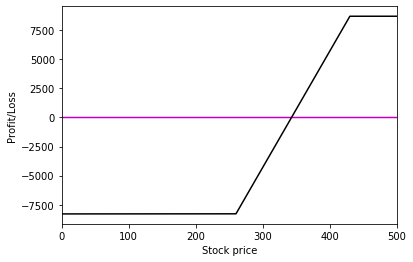

In [6]:
zeroline=zeros(s.shape[0])
plt.xlabel("Stock price")
plt.ylabel("Profit/Loss")
plt.xlim(0,500)
plt.plot(s,zeroline,'m-')
plt.plot(s,pl_total,'k-')